# FERNANDO LEON FRANCO | PRACTICA DE TCOR

In [31]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from colorstreak import Logger
import re
from sklearn.feature_selection import SelectKBest, chi2
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud


In [32]:
def print_bar(i, cantidad_registros, contexto="PROGRESO"):
    porcentaje = (i + 1) / cantidad_registros * 100
    # Con emojis
    barra = int(50 * (i + 1) / cantidad_registros) * "🟩"
    espacio = int(50 - len(barra)) * "⬛️"

    print(f"\r{contexto}: |{barra}{espacio}| {porcentaje:6.2f}%", end="", flush=True)

In [33]:
def get_texts_from_file(path_corpus, path_truth):

    tr_txt = [] # Aqui van los twits
    tr_y = [] # Aqui van las etiquetas

    with open(path_corpus, 'r', encoding='utf-8') as f_corpus, open(path_truth , 'r', encoding='utf-8') as f_truth:
        
        for twitt in f_corpus:
            tr_txt += [twitt]
            
        for label in f_truth:
            tr_y += [label]
    
    return tr_txt,tr_y        

In [34]:
path_global = "data/mex"
path_corpus = path_global + '/mex20_train.txt'
path_truth = path_global + '/mex20_train_labels.txt'


tr_txt, tr_y = get_texts_from_file(path_corpus,path_truth)



# Construir los datos de validación
path_corpus = path_global + '/mex20_val.txt'
path_truth = path_global + '/mex20_val_labels.txt'


va_txt, va_y = get_texts_from_file(path_corpus,path_truth)


# TOKENIZACIÓN

In [35]:
tokenizer = TweetTokenizer()
corpus_de_palabras = []

for doc in tr_txt:
    corpus_de_palabras += tokenizer.tokenize(doc)
    
fdist = nltk.FreqDist(corpus_de_palabras)


In [36]:
"""
VERSION DEL PROFE
"""


def sort_dist(freq_dist):
    aux = [(freq_dist[key], key) for key in freq_dist.keys()]
    aux.sort(reverse=True)
    return aux

vocabulario = sort_dist(fdist)

vocabulario = vocabulario[:5000] # Shape (5000, 2)


# Es redundante pero asegura un orden en diccionario en Python (No importa por que python se indexa)

dict_indices = {}

contador = 0

for peso, palabra in vocabulario:
    dict_indices[palabra] = contador
    contador += 1
    

def built_bow_tr_profe_version(tuits, Vocabulario, dict_indices):
    
    BOW = np.zeros((len(tuits), len(Vocabulario)), dtype=int)

    contador = 0
    for tr in tuits:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr.lower())) # Tuit Tokenizado
        for palabra in fdist_doc:
            if palabra in dict_indices:
                BOW[contador, dict_indices[palabra]] = fdist_doc[palabra] # FRECUENCIA DE LA PALABRA EN VEZ DE HACERLO BINARIO
        contador += 1
    return BOW


In [37]:
bolsa_de_palabras_tr = built_bow_tr_profe_version(tr_txt, vocabulario, dict_indices)
bolsa_de_palabras_tr

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], shape=(5278, 5000))

# CONSTRUIR MATRIZ DE CO-OCURRENCIA DE TERMINO VS TERMINO

In [38]:
def compute_tcor(bow):
    DTR = np.zeros((bow.shape[1], bow.shape[1]),dtype=np.float64)
    print(f"La matriz de palabras tiene forma: {bow.shape}")
    print(f"La matriz de co-ocurrencia tendrá forma: {DTR.shape}")
    
    # Recorrer cada documento en su representación BOW
    for doc,i in zip(bow, range(len(bow))):
        nonzero_positions = np.nonzero(doc)[0]
        for termino_1 in nonzero_positions:
            for termino_2 in nonzero_positions:
                DTR[termino_1, termino_2] += 1.0
    
    
    return DTR # Distribución de términos por términos ( Embedding distribucional)

In [39]:
tcor_base = compute_tcor(bolsa_de_palabras_tr)
# Normalizar

tcor_base = preprocessing.normalize(tcor_base, norm='l2')



La matriz de palabras tiene forma: (5278, 5000)
La matriz de co-ocurrencia tendrá forma: (5000, 5000)


# FEATURE SELECTION

In [40]:
feature_selector = SelectKBest(chi2, k=1000)
feature_selector.fit(bolsa_de_palabras_tr, tr_y)  # o bow_train_frecuencia, como prefieras
best = feature_selector.get_support(indices=True)

# DICCIONARIO INVERTIDO

In [41]:
dict_indices_invertido = {valor: key for key, valor in dict_indices.items()}
dict_indices_invertido

{0: ',',
 1: 'de',
 2: 'que',
 3: '.',
 4: 'la',
 5: 'a',
 6: 'y',
 7: '!',
 8: 'no',
 9: '@USUARIO',
 10: 'me',
 11: 'el',
 12: 'en',
 13: 'se',
 14: 'es',
 15: 'con',
 16: '?',
 17: 'verga',
 18: 'los',
 19: 'madre',
 20: 'por',
 21: 'las',
 22: '"',
 23: 'un',
 24: 'te',
 25: 'mi',
 26: 'lo',
 27: 'putas',
 28: 'una',
 29: '...',
 30: 'putos',
 31: 'para',
 32: '😂',
 33: 'si',
 34: 'ya',
 35: 'como',
 36: 'su',
 37: 'pero',
 38: 'tu',
 39: 'loca',
 40: 'le',
 41: 'más',
 42: 'No',
 43: 'del',
 44: 'gorda',
 45: 'al',
 46: 'bien',
 47: 'A',
 48: '¿',
 49: 'Y',
 50: 'son',
 51: 'Me',
 52: 'o',
 53: 'feas',
 54: 'cuando',
 55: 'Que',
 56: ':',
 57: 'yo',
 58: 'les',
 59: 'porque',
 60: 'ni',
 61: 'está',
 62: 'ser',
 63: 'estoy',
 64: 'sus',
 65: 'todos',
 66: 'esta',
 67: 'puta',
 68: 'Ya',
 69: 'todo',
 70: 'pinche',
 71: 'puto',
 72: 'tan',
 73: 'Si',
 74: 'La',
 75: 'qué',
 76: '…',
 77: 'eso',
 78: 'muy',
 79: 'soy',
 80: 'hasta',
 81: 'así',
 82: '¡',
 83: '<URL>',
 84: 'mamar',


# PALABRAS OBJETIVO

In [42]:
t_words = [dict_indices_invertido[index] for index in best]

target_matrix = np.array([tcor_base[dict_indices[word]] for word in t_words])

# REDUCCIÓN DE DIMENSIONALIDAD

In [43]:
from sklearn.manifold import TSNE


reduce_matrix = TSNE(n_components=2).fit_transform(target_matrix)


# REPRESENTACIÓN GRÁFICA

/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWa

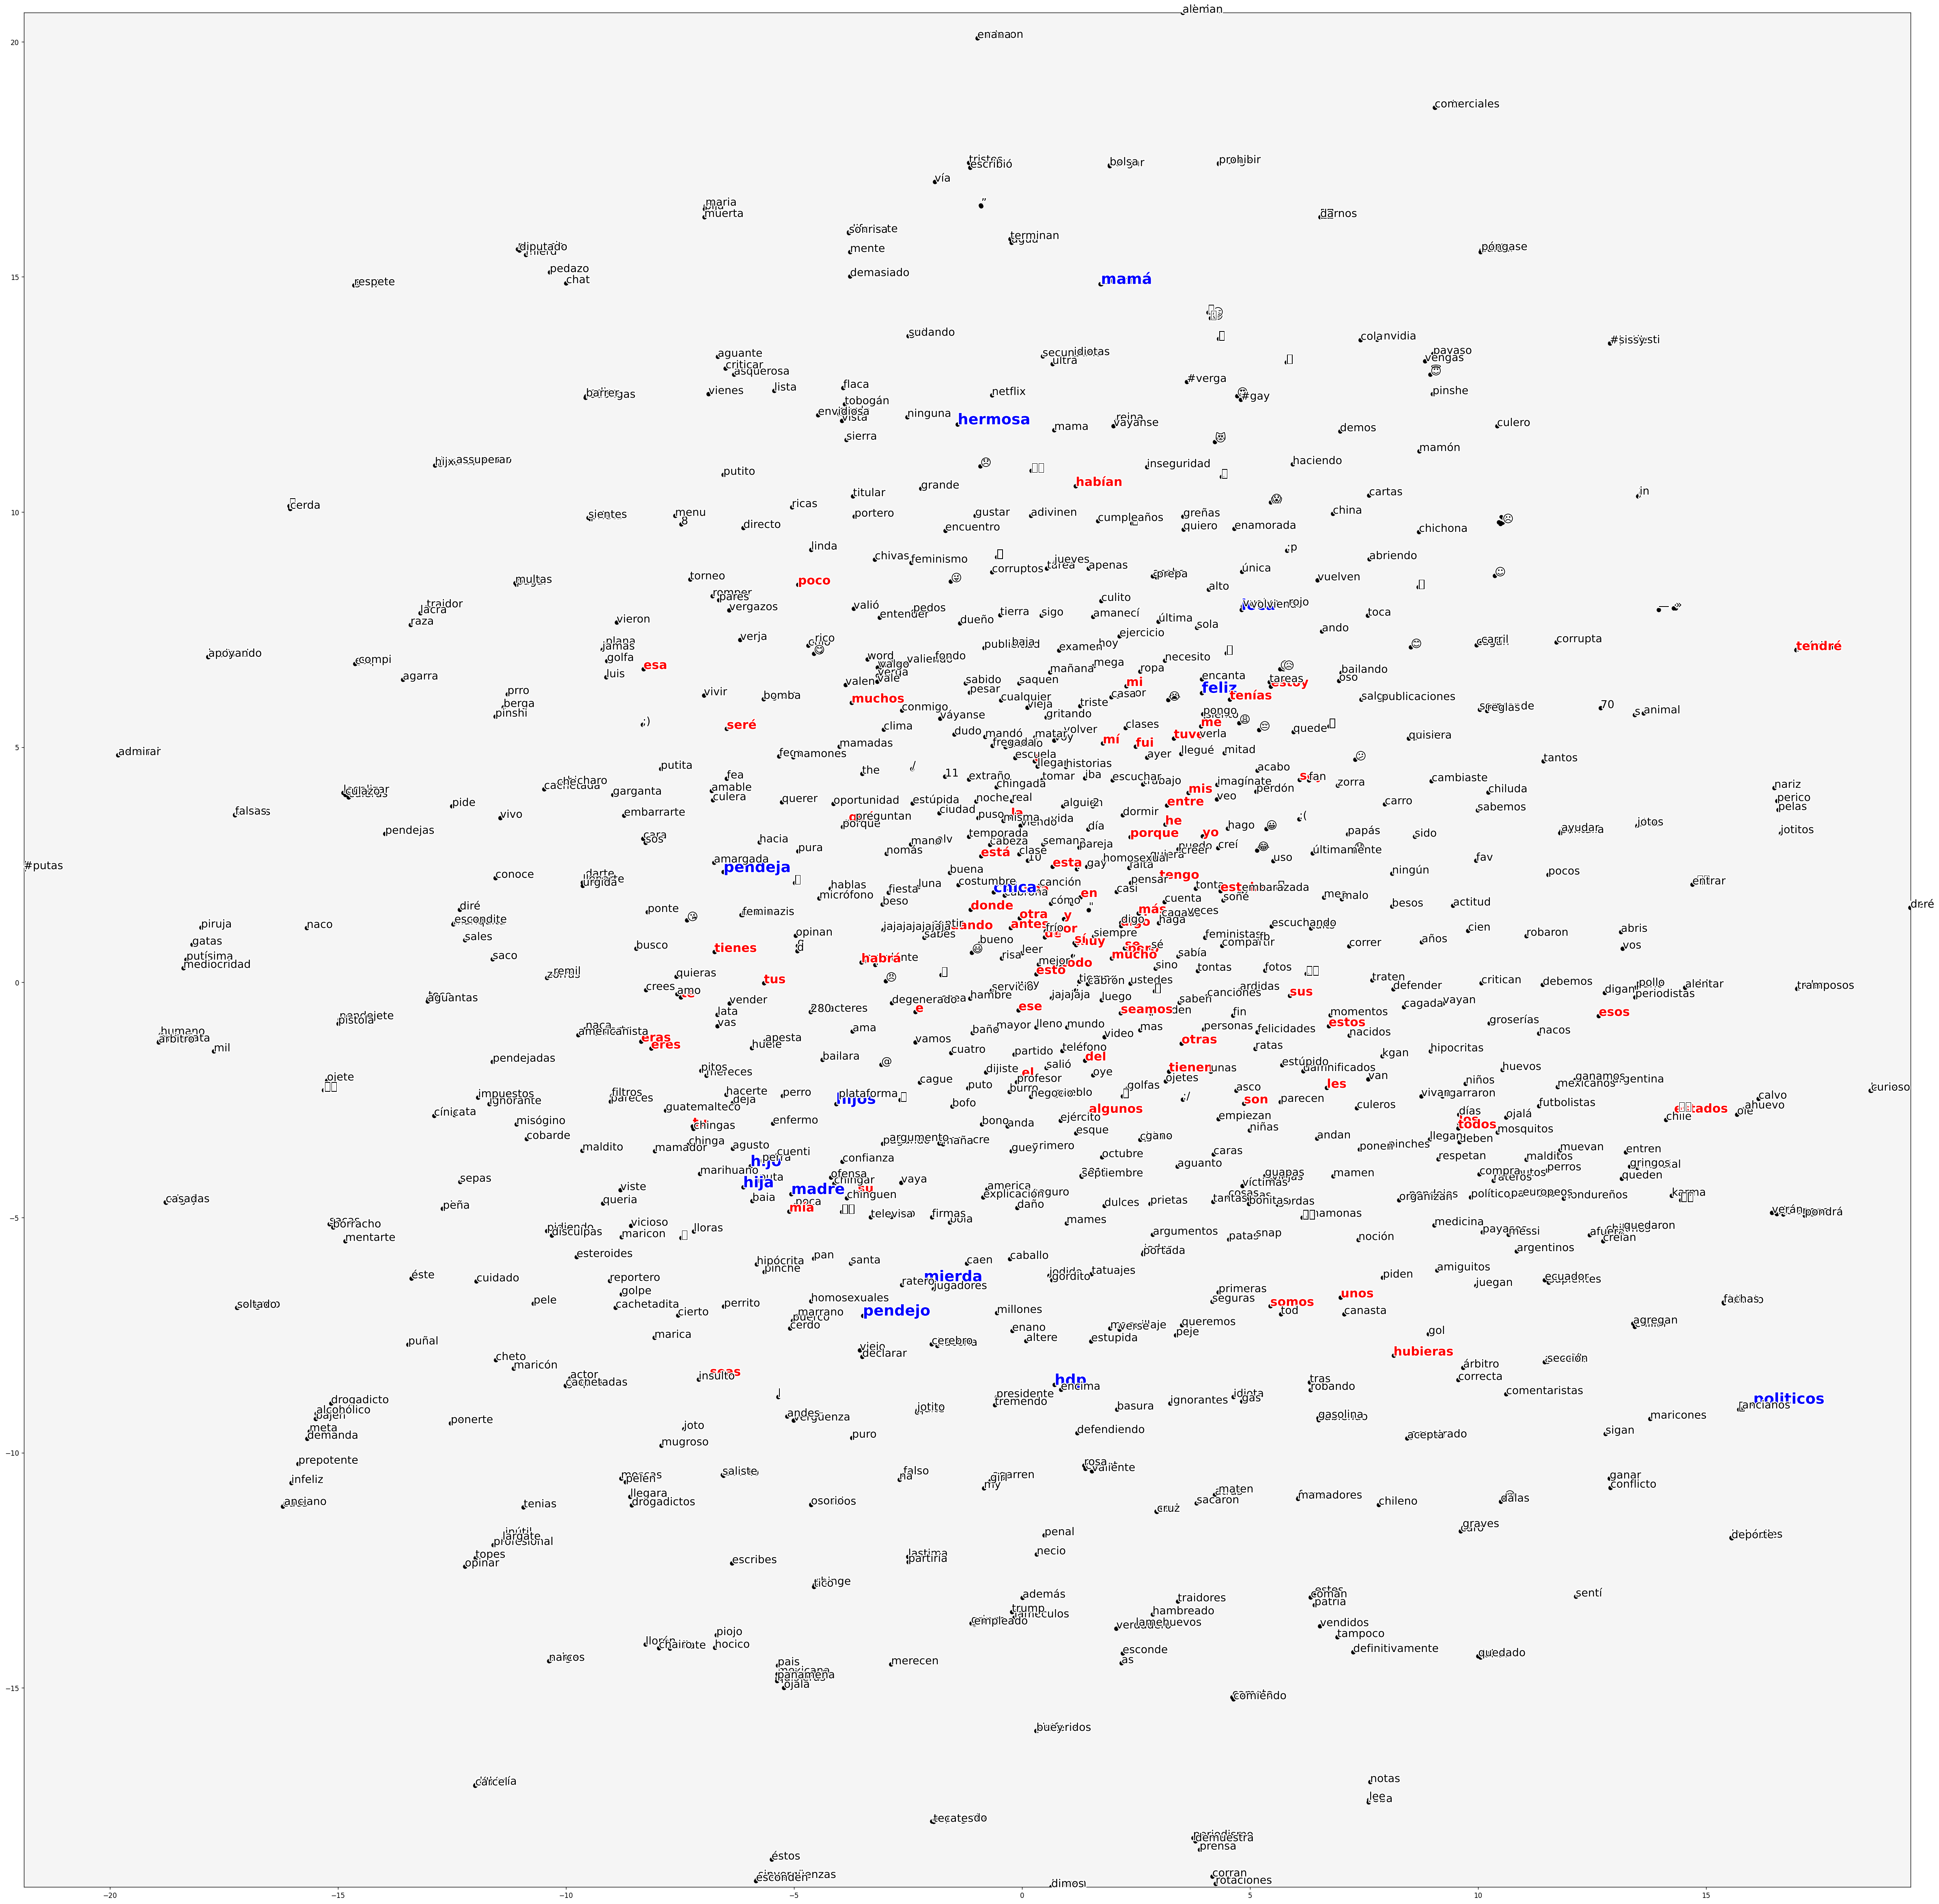

In [44]:
from matplotlib import patheffects
max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)



x, y = reduce_matrix[:, 0], reduce_matrix[:, 1]

plt.figure(figsize=(50, 50), dpi=120)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.scatter(x, y, s=30, color='black')






stop_words = stopwords.words('spanish')


for i, word in enumerate(t_words):
    if word in stop_words:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=18, 
            color='red', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    elif word in ['politicos', 'corrupción', 'PRI', 'feliz', 
              'hermosa', 'chica', 'tu', 'hdp','madre','madres',
              '@usuario' ,'hijos', 'pendeja', 'pendejo','mierda', 
              'loca', 'hijo', 'hija', 'mamá', 'tía']:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=22, 
            color='blue', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    else:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=16, 
            color='black',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )

plt.gca().set_facecolor('whitesmoke')
plt.show()


# NUBE DE PALABRAS

[DEBUG]  Puntajes Chi2 de las mejores palabras: [  3.88391302  13.8004089    2.94580155  12.75322961  46.77952725
   2.56301765  59.2469122  138.32941578   4.39519919  31.16513
   2.66748382  24.00223476  33.23692121  15.68528246   2.26619156
  36.89974641  12.94850591  62.55989316  11.30388828 171.39595343
   7.65508256  33.5026597   12.54041039 179.859082   106.404039
   2.6754506    5.00491413   4.07948961  16.80930549  29.20523722
   3.96828498  12.2452227   14.4983931   36.6673755    3.77640427
  13.96444233  16.16114763  56.7995841   12.35734143   3.85458481
  11.63277971 117.74826774   3.64399071 215.96459656  21.79650752
   2.37386491   3.55248136  40.27135417  24.70732766  17.64091506
  46.40316741  28.57898617  12.19662671  12.50198692   5.33435576
   3.32203265  15.7145895    9.89299463  37.87238396  16.79305611
   2.06274833   5.97806434   2.1366729   24.93051593  97.44410479
   9.7407768   24.47530944   4.7115954   23.28690712   3.57277416
  27.58840289  21.08888369 289.81

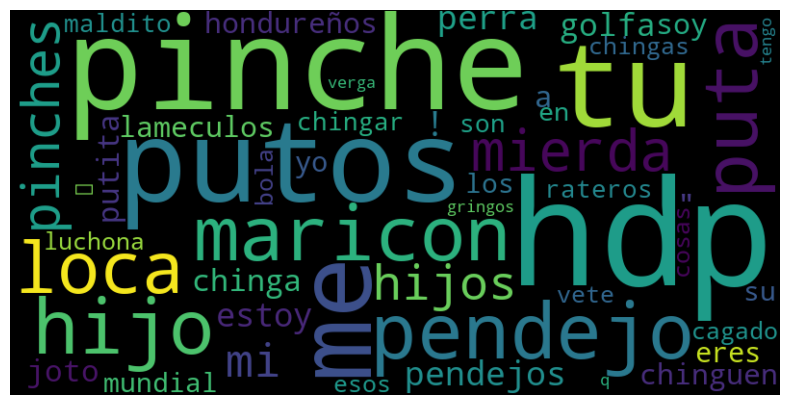

In [45]:

# Chi2


feature_selector = SelectKBest(chi2, k=1000)
feature_selector.fit(bolsa_de_palabras_tr, tr_y) # EL tr_y son las etiquetas agresivo o no agresivo


# Extraer las palabras seleccionadas
palabras_mejores_indices = feature_selector.get_support(indices=True)
palabras = [dict_indices_invertido[indice] for indice in palabras_mejores_indices]


# Extraer los scores
chi2_scores = feature_selector.scores_
best_scores = chi2_scores[palabras_mejores_indices] # type: ignore
Logger.debug(f" Puntajes Chi2 de las mejores palabras: {best_scores}")


# Distribución de frecuencias
distribucion_frecuencias_tweets = {palabra: score for palabra, score in zip(palabras, best_scores)} # type: ignore
mejores_50 = dict(sorted(distribucion_frecuencias_tweets.items(), key=lambda item: item[1], reverse=True)[:50])
Logger.debug(f"Frecuencia de palabras en tweets: {mejores_50}")

# Generar y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(mejores_50)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
